# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Doge cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 125 # approx 8 years
TICKER = "DOGEUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR="DOGEUSDT:high"
TIME = "DOGEUSDT:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2019-07-05 12:00:00,0.00449000,0.00460000,0.00376000,0.00392490,949430724.00000000
1,2019-07-05 13:00:00,0.00391530,0.00392840,0.00376500,0.00383530,159004267.00000000
2,2019-07-05 14:00:00,0.00384500,0.00392000,0.00381390,0.00384130,105517060.00000000
3,2019-07-05 15:00:00,0.00383730,0.00386890,0.00371000,0.00373790,100804728.00000000
4,2019-07-05 16:00:00,0.00372760,0.00373380,0.00363640,0.00366640,120261079.00000000
...,...,...,...,...,...,...
49726,2025-03-08 15:00:00,0.19505000,0.19591000,0.19385000,0.19465000,16743376.00000000
49727,2025-03-08 16:00:00,0.19466000,0.19511000,0.19109000,0.19281000,61039299.00000000
49728,2025-03-08 17:00:00,0.19281000,0.19446000,0.19113000,0.19336000,44063964.00000000
49729,2025-03-08 18:00:00,0.19336000,0.19390000,0.19275000,0.19381000,14397566.00000000


In [4]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,DOGEUSDT:time,DOGEUSDT:high,DOGEUSDT:low,DOGEUSDT:close,DOGEUSDT:volume
0,2019-07-05 13:00:00,0.334585,-3.838786,-2.043266,-83.252673
1,2019-07-05 14:00:00,1.950585,-0.808843,-0.096229,-33.638850
2,2019-07-05 15:00:00,0.823496,-3.317437,-2.590363,-4.465943
3,2019-07-05 16:00:00,0.166327,-2.446614,-1.641807,19.301030
4,2019-07-05 17:00:00,0.573927,-2.978956,-0.858158,23.294189
...,...,...,...,...,...
49725,2025-03-08 15:00:00,0.440913,-0.615227,-0.205076,-8.916392
49726,2025-03-08 16:00:00,0.231172,-1.833967,-0.950375,264.557894
49727,2025-03-08 17:00:00,0.855765,-0.871324,0.285255,-27.810501
49728,2025-03-08 18:00:00,0.279272,-0.315474,0.232727,-67.325759


In [5]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
high_data_processed = processed_data[f"{TICKER}:high"].to_list()

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in high_data_processed) / len(high_data_processed)}")
print("----------------------------------------------------------------------")

close_data_processed = processed_data[f"{TICKER}:close"].to_list()

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.6 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.7 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.8 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.9 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

MAX HIGH IN DATASET: 69.83591186122831
OCCURRENCES OVER 0.5: 22652 - PERCENT OF DATASET: 0.4554996983712045
OCCURRENCES OVER 0.6: 19257 - PERCENT OF DATASET: 0.38723104765734967
OCCURRENCES OVER 0.7: 16550 - PERCENT OF DATASET: 0.33279710436356325
OCCURRENCES OVER 0.8: 14258 - PERCENT OF DATASET: 0.28670822441182386
OCCURRENCES OVER 0.9: 12457 - PERCENT OF DATASET: 0.2504926603659763
OCCURRENCES OVER 1: 10912 - PERCENT OF DATASET: 0.21942489442992158
----------------------------------------------------------------------
MAX CLOSE IN DATASET: 69.76966509712794
OCCURRENCES OVER 0.5: 10694 - PERCENT OF DATASET: 0.21504122260205108
OCCURRENCES OVER 0.6: 9120 - PERCENT OF DATASET: 0.1833903076613714
OCCURRENCES OVER 0.7: 7723 - PERCENT OF DATASET: 0.1552986125075407
OCCURRENCES OVER 0.8: 6620 - PERCENT OF DATASET: 0.1331188417454253
OCCURRENCES OVER 0.9: 5712 - PERCENT OF DATASET: 0.11486024532475367
OCCURRENCES OVER 1: 4960 - PERCENT OF DATASET: 0.09973858837723708


In [6]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,DOGEUSDT:high0,DOGEUSDT:low0,DOGEUSDT:close0,DOGEUSDT:volume0,DOGEUSDT:high1,DOGEUSDT:low1,DOGEUSDT:close1,DOGEUSDT:volume1,DOGEUSDT:high2,...,DOGEUSDT:volume2,DOGEUSDT:high3,DOGEUSDT:low3,DOGEUSDT:close3,DOGEUSDT:volume3,DOGEUSDT:high4,DOGEUSDT:low4,DOGEUSDT:close4,DOGEUSDT:volume4,Label
0,2019-07-05 17:00:00,0.334585,-3.838786,-2.043266,-83.252673,1.950585,-0.808843,-0.096229,-33.638850,0.823496,...,-4.465943,0.166327,-2.446614,-1.641807,19.301030,0.573927,-2.978956,-0.858158,23.294189,1
1,2019-07-05 18:00:00,1.950585,-0.808843,-0.096229,-33.638850,0.823496,-3.317437,-2.590363,-4.465943,0.166327,...,19.301030,0.573927,-2.978956,-0.858158,23.294189,3.009719,-1.170753,0.508063,-60.244488,1
2,2019-07-05 19:00:00,0.823496,-3.317437,-2.590363,-4.465943,0.166327,-2.446614,-1.641807,19.301030,0.573927,...,23.294189,3.009719,-1.170753,0.508063,-60.244488,2.330439,-0.096186,1.354842,24.010361,1
3,2019-07-05 20:00:00,0.166327,-2.446614,-1.641807,19.301030,0.573927,-2.978956,-0.858158,23.294189,3.009719,...,-60.244488,2.330439,-0.096186,1.354842,24.010361,1.355638,-1.751484,0.612748,-42.029380,1
4,2019-07-05 21:00:00,0.573927,-2.978956,-0.858158,23.294189,3.009719,-1.170753,0.508063,-60.244488,2.330439,...,24.010361,1.355638,-1.751484,0.612748,-42.029380,1.835134,-0.921609,-0.021558,8.045463,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49720,2025-03-08 14:00:00,0.637008,-0.118155,0.297955,-45.423295,0.005122,-1.131882,-0.481434,69.234234,0.591807,...,-1.390889,0.579725,-0.353991,0.256515,-36.642275,0.639681,-0.260990,-0.184228,24.186183,0
49721,2025-03-08 15:00:00,0.005122,-1.131882,-0.481434,69.234234,0.591807,-0.504323,0.308769,-1.390889,0.579725,...,-36.642275,0.639681,-0.260990,-0.184228,24.186183,0.440913,-0.615227,-0.205076,-8.916392,0
49722,2025-03-08 16:00:00,0.591807,-0.504323,0.308769,-1.390889,0.579725,-0.353991,0.256515,-36.642275,0.639681,...,24.186183,0.440913,-0.615227,-0.205076,-8.916392,0.231172,-1.833967,-0.950375,264.557894,1
49723,2025-03-08 17:00:00,0.579725,-0.353991,0.256515,-36.642275,0.639681,-0.260990,-0.184228,24.186183,0.440913,...,-8.916392,0.231172,-1.833967,-0.950375,264.557894,0.855765,-0.871324,0.285255,-27.810501,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [7]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250308_194216"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.57 GB / 15.92 GB (41.3%)
Disk Space Avail:   179.72 GB / 475.69 GB (37.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [8]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


39725    0
39726    0
39727    0
39728    0
39729    0
        ..
49720    0
49721    0
49722    1
49723    1
49724    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.6583,
 'balanced_accuracy': 0.6584975765143665,
 'mcc': 0.3174263618450354,
 'roc_auc': 0.7159323939353015,
 'f1': 0.6503632456768649,
 'precision': 0.6708887481528394,
 'recall': 0.631056393963463,
 'confusion_matrix':       0     1
 0  3405  1559
 1  1858  3178,
 'classification_report': {'0': {'precision': 0.6469694090822725,
   'recall': 0.6859387590652699,
   'f1-score': 0.665884423584629,
   'support': 4964.0},
  '1': {'precision': 0.6708887481528394,
   'recall': 0.631056393963463,
   'f1-score': 0.6503632456768649,
   'support': 5036.0},
  'accuracy': 0.6583,
  'macro avg': {'precision': 0.6589290786175559,
   'recall': 0.6584975765143665,
   'f1-score': 0.658123834630747,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6590151882382099,
   'recall': 0.6583,
   'f1-score': 0.6580679583902789,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	169.08s	= Expected runtime (33.82s per shuffle set)
	52.92s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
DOGEUSDT:high4,0.02544,0.004900,0.000157,5,0.035529,0.015351
DOGEUSDT:low4,0.01024,0.004462,0.003415,5,0.019427,0.001053
DOGEUSDT:close4,0.00920,0.002939,0.001097,5,0.015252,0.003148
DOGEUSDT:high3,0.00680,0.004785,0.016809,5,0.016653,-0.003053
DOGEUSDT:low3,0.00580,0.007355,0.076318,5,0.020945,-0.009345
DOGEUSDT:high0,0.00480,0.002445,0.005895,5,0.009835,-0.000235
DOGEUSDT:low0,0.00416,0.001043,0.000437,5,0.006308,0.002012
DOGEUSDT:high2,0.00332,0.004360,0.081929,5,0.012298,-0.005658
DOGEUSDT:low2,0.00284,0.005268,0.147213,5,0.013686,-0.008006
DOGEUSDT:low1,0.00236,0.004713,0.162746,5,0.012063,-0.007343


In [9]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.863997,0.136003
1,0.863736,0.136264
2,0.790394,0.209606
3,0.819808,0.180192
4,0.747448,0.252552
...,...,...
9995,0.597617,0.402383
9996,0.600800,0.399200
9997,0.462140,0.537860
9998,0.493055,0.506945


,Label
0,0
1,0
2,0
3,0
4,0
...,...
9995,0
9996,0
9997,1
9998,1


,DOGEUSDT:high0,DOGEUSDT:low0,DOGEUSDT:close0,DOGEUSDT:volume0,DOGEUSDT:high1,DOGEUSDT:low1,DOGEUSDT:close1,DOGEUSDT:volume1,DOGEUSDT:high2,DOGEUSDT:low2,...,DOGEUSDT:volume2,DOGEUSDT:high3,DOGEUSDT:low3,DOGEUSDT:close3,DOGEUSDT:volume3,DOGEUSDT:high4,DOGEUSDT:low4,DOGEUSDT:close4,DOGEUSDT:volume4,Label
0,0.319332,-0.196512,-0.098256,61.016300,0.319646,-0.110647,0.258176,-49.757941,0.049050,-0.429185,...,119.167598,0.246214,-0.036932,0.098486,-45.501593,0.184502,-0.123001,-0.098401,-21.904168,0
1,0.319646,-0.110647,0.258176,-49.757941,0.049050,-0.429185,-0.380135,119.167598,0.246214,-0.036932,...,-45.501593,0.184502,-0.123001,-0.098401,-21.904168,0.098486,-0.406254,-0.049243,87.109852,0
2,0.049050,-0.429185,-0.380135,119.167598,0.246214,-0.036932,0.098486,-45.501593,0.184502,-0.123001,...,-21.904168,0.098486,-0.406254,-0.049243,87.109852,0.221675,-0.628079,-0.541872,7.188350,0
3,0.246214,-0.036932,0.098486,-45.501593,0.184502,-0.123001,-0.098401,-21.904168,0.098486,-0.406254,...,87.109852,0.221675,-0.628079,-0.541872,7.188350,0.272412,-0.099059,-0.024765,-6.237381,0
4,0.184502,-0.123001,-0.098401,-21.904168,0.098486,-0.406254,-0.049243,87.109852,0.221675,-0.628079,...,7.188350,0.272412,-0.099059,-0.024765,-6.237381,0.235323,-0.507803,-0.371563,46.180867,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.637008,-0.118155,0.297955,-45.423295,0.005122,-1.131882,-0.481434,69.234234,0.591807,-0.504323,...,-1.390889,0.579725,-0.353991,0.256515,-36.642275,0.639681,-0.260990,-0.184228,24.186183,0
9996,0.005122,-1.131882,-0.481434,69.234234,0.591807,-0.504323,0.308769,-1.390889,0.579725,-0.353991,...,-36.642275,0.639681,-0.260990,-0.184228,24.186183,0.440913,-0.615227,-0.205076,-8.916392,0
9997,0.591807,-0.504323,0.308769,-1.390889,0.579725,-0.353991,0.256515,-36.642275,0.639681,-0.260990,...,24.186183,0.440913,-0.615227,-0.205076,-8.916392,0.231172,-1.833967,-0.950375,264.557894,1
9998,0.579725,-0.353991,0.256515,-36.642275,0.639681,-0.260990,-0.184228,24.186183,0.440913,-0.615227,...,-8.916392,0.231172,-1.833967,-0.950375,264.557894,0.855765,-0.871324,0.285255,-27.810501,0


MEAN PROB 1 CLASSIFICATION: 0.4870108943283558
MAX PROB 1 CLASSIFICATION: 0.9663752913475037
MIN PROB 1 CLASSIFICATION: 0.09004026651382446
COUNT OF NUMBERS > 0.7: 1091
COUNT OF NUMBERS > 0.8: 288
COUNT OF NUMBERS > 0.9: 25


CORRECT: 24
WRONG: 1
NUMBER OF TRADES: 25
WIN RATE: 96.0%
RETURN: 11.83%
INVESTMENT VALUE: 111.83kr
SHARP RATIO: 4.366645899450234
SHARP RATIO ONLY HOLDING ASSET: 1.3204411339642625
MEAN RETURN BAD TRADES: -0.782
----------------------------------
-0.782


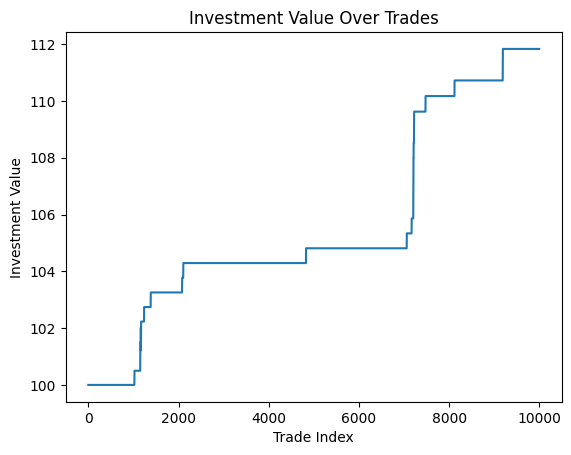

In [46]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.9
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = validation_dataset[f"{TICKER}:close4"][idx + 1]
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}kr")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [24]:
######################## OLD FILE #################################
##################### PROBABILITY ANALYSIS AND EXPECTED RETURNS
################# Probability analysis ###########################
import statistics as st

# Minimum required confidence for executing a trade
PROB_THRESH = 0.65
LEVERAGE = 1

# display(test_tabular_dataset)
# display(test_data_frame2[LABEL][len(labelled_data_frame) - VALIDATION_SIZE])


y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_prob)

counter = 0
correct = 0

predicted_high_list = []
predicted_low_list = []
predicted_close_list = []

balance = 100

hour_count = 0
month_gain = []
month = 100


first_index_dataset = len(labelled_data_frame) - VALIDATION_SIZE

print("------------------- TRADES: ------------------------------")
for index, pred in enumerate(y_pred):
    try:
        index = index + first_index_dataset
        prob = y_prob[1][index]
        actual = test_data_frame2["Label"][index]

        true_high = test_data_frame2[f"{TICKER}:high4"][index + 1]
        true_low = test_data_frame2[f"{TICKER}:low4"][index + 1]
        true_close = test_data_frame2[f"{TICKER}:close4"][index + 1]
        

        if prob > PROB_THRESH:
            counter += 1

            if pred == 1 and actual == 1:
                correct += 1
                predicted_high_list.append(true_high)
                predicted_low_list.append(true_low)
                predicted_close_list.append(true_close)

            ### LOGIC FOR CALCULATING GAIN ###
            if true_high >= 0.5:
                balance *= 1 + (0.005 * LEVERAGE)
                month *= 1 + (0.005 * LEVERAGE)
                print(f"{index}. Gain +5%")
            else:
                balance *= 1 + ((true_close / 100) * LEVERAGE)
                month *= 1 + ((true_close / 100) * LEVERAGE)
                #print(f"{index}. Close + {true_close} ---> High: {true_high}, Low: {true_low}, Close: {true_close}")
                print(f"{index}. Close +{true_close * LEVERAGE}")
    
        hour_count += 1
        if hour_count == 730:
            hour_count = 0
            month_gain.append(round(month - 100, 3))
            month = 100

    except Exception as e:
        print(f"Got following error: {e}")


month_gain.append(month - 100)

        

print("------------------------------------------")
print(f"Correct: {correct}")
print(f"Counter: {counter}")
print(f"Winrate: {correct / counter}")

print(f"AVG High: {st.mean(predicted_high_list)}")
print(f"AVG Low: {st.mean(predicted_low_list)}")
print(f"AVG Close: {st.mean(predicted_close_list)}")
print()
print(f"Balance: {balance}")
print(f"Return: {balance - 100}%")
print()
print(f"Month List: {month_gain}")
print(f"Mean month gain: {st.mean(month_gain)}")

------------------- TRADES: ------------------------------
39398. Close +-1.270934790355151
39400. Gain +5%
39464. Gain +5%
39508. Close +-0.22339027595269842
39509. Gain +5%
39547. Close +-0.07463614877472882
39550. Gain +5%
39551. Gain +5%
39552. Close +0.38008361839604043
39566. Gain +5%
39593. Gain +5%
39594. Gain +5%
39617. Close +-1.8872489716912557
39618. Gain +5%
39814. Gain +5%
39816. Gain +5%
39817. Gain +5%
39818. Gain +5%
39819. Close +0.15590200445434435
39821. Close +-0.41479433114414005
39823. Gain +5%
39860. Gain +5%
39861. Gain +5%
39863. Close +-0.3080335140463285
39875. Gain +5%
40022. Gain +5%
40023. Gain +5%
40456. Gain +5%
40541. Gain +5%
40552. Close +-1.7892413152085511
40553. Close +-0.7216372885366136
40717. Gain +5%
40719. Close +-1.6433602123098912
40720. Gain +5%
40721. Gain +5%
40722. Close +-1.3187718936740054
40723. Gain +5%
40725. Gain +5%
40726. Close +-0.6804793824903553
40729. Close +-0.030740854595760064
40731. Close +-0.24955807424353132
40732. Clo

CORRECT: 12
WRONG: 13
NUMBER OF TRADES: 25
WIN RATE: 48.0%
----------------------------------
MEAN GOOD TRADES: 3.804923692221088
MEAN BAD TRADES: -1.4002931029371015
RETURN: 29.581 %


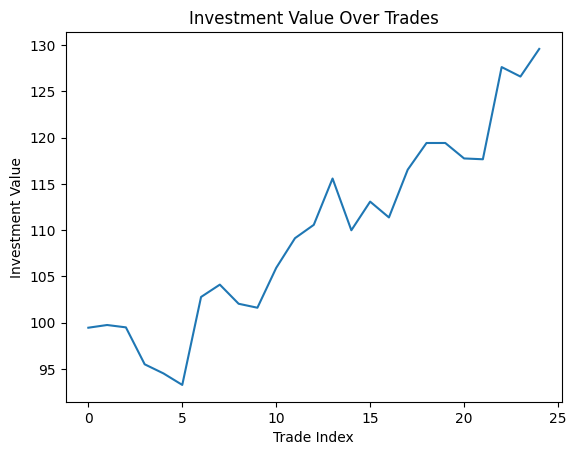

In [ ]:
############### ANALYSIS OF CLOSING VALUE PREDICTIONS ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.9
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0.25:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()